In [ ]:
!pip install umap-learn
!pip install lazypredict
!pip install pytorch-tabnet
!pip install catboost
!pip install pyod

Датасет можно скачать [здесь](https://www.kaggle.com/datasets/ellipticco/elliptic-data-set)

Или можно просто запустить код, который представлен ниже. Не забудьте поменять значение переменной **path_to_folder**

In [ ]:
!pip install kaggle
!mkdir content/kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download ellipticco/elliptic-data-set
!unzip /content/elliptic-data-set.zip

# Imports and read data

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import numpy as np
import plotly.graph_objs as go
import umap
import networkx as nx
from google.colab import drive, userdata
import time
import sys
import os
from tqdm import tqdm

# -
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score, precision_score, recall_score, balanced_accuracy_score, accuracy_score
from sklearn.datasets import load_breast_cancer

# -
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from pyod.models.cblof import CBLOF
from pyod.models.abod import ABOD
from sklearn.ensemble import IsolationForest

# -
from lazypredict.Supervised import LazyClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
import catboost
from catboost import CatBoostClassifier, Pool

# -
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
# Подключаем гугл диск
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Объявляем путь до данных
path_to_folder = userdata.get('path_VTB')

# Формируем название колонок для фич
colNames = ['txId', 'Time step']
colNames_local = [f"Local_feature_{i + 1}" for i in range(93)]
colNames_agg = [f"Aggregate_feature_{i + 1}" for i in range(72)]
colNames.extend(colNames_local)
colNames.extend(colNames_agg)


# Загружаем данные
classes = pd.read_csv(path_to_folder + '/elliptic_bitcoin_dataset/elliptic_txs_classes.csv')
edgelist = pd.read_csv(path_to_folder + '/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')
features = pd.read_csv(path_to_folder + '/elliptic_bitcoin_dataset/elliptic_txs_features.csv', names=colNames)


# Добавляем названием классов
class_name = {'2': 'Законный', '1': 'Незаконный', '0': 'Неизвестный'}
classes.loc[classes['class'] == 'unknown', 'class'] = '0'
classes['class_name'] = classes['class'].apply(lambda name: class_name[name])

# Объединяем фичи с классами
df_merge = features.merge(classes, how='left', right_on="txId", left_on='txId')

In [ ]:
df_merge.head(2)

,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,...,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72,class,class_name
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162097,...,1.461330,1.461369,0.018279,-0.08749,-0.131155,-0.097524,-0.120613,-0.119792,0,Неизвестный
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162112,...,-0.979074,-0.978556,0.018279,-0.08749,-0.131155,-0.097524,-0.120613,-0.119792,0,Неизвестный


# EDA

In [7]:
# Задаем стиль графикам
sns.set_style("whitegrid")

Визуализируем баланс классов

In [ ]:
class_count = dict(classes.groupby(by=['class_name']).agg('count').iloc[:, 0])
classes.groupby(by=['class_name']).agg('count').iloc[:, 0].to_frame()

,txId
class_name,
Законный,42019
Незаконный,4545
Неизвестный,157205


<Axes: xlabel='class_name', ylabel='Count'>

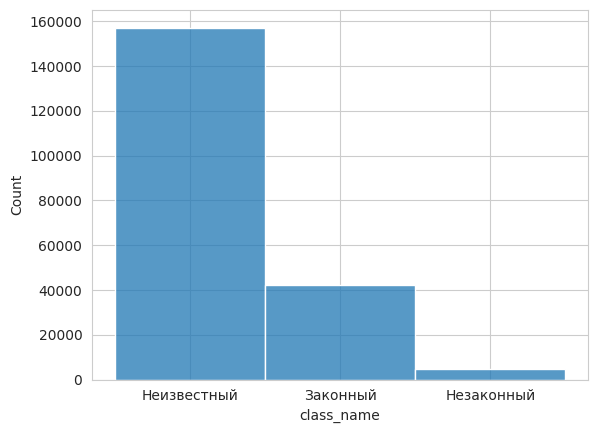

In [ ]:
sns.histplot(data=classes['class_name'])

Анализируем распределение данных по Time step с нормированием количества

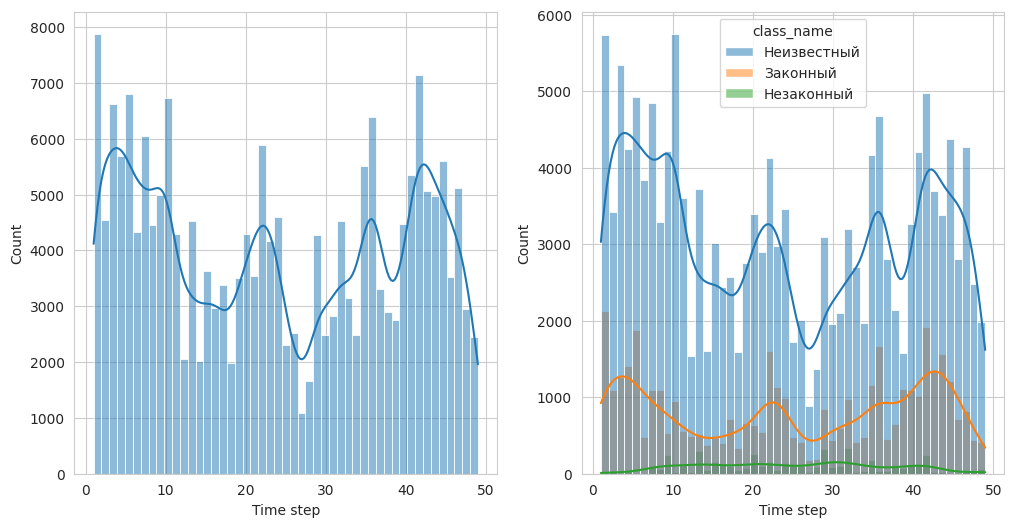

In [ ]:
# Создаем график с двумя подграфиками на одной строке
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data=df_merge['Time step'], ax=axes[0], kde=True)
sns.histplot(data=df_merge, x='Time step', hue='class_name', ax=axes[1], kde=True)

# Отображение графиков
plt.show()

In [ ]:
# Получаем коэффиценты различия количества классов данных
k_licit_ilict = class_count['Законный'] / class_count['Незаконный']
k_know_ilict = class_count['Неизвестный'] / class_count['Незаконный']

# Формируем датасет с количеством классов на каждый step
grouped_data = df_merge.groupby(['Time step', 'class_name']).size().reset_index(name='count')

# Нормируем данные
df_legal = grouped_data[grouped_data['class_name'] == 'Законный'].copy()
df_illegal = grouped_data[grouped_data['class_name'] == 'Незаконный'].copy()
df_know = grouped_data[grouped_data['class_name'] == 'Неизвестный'].copy()

df_legal['count'] = round(df_legal['count'] / k_licit_ilict).astype(int)
df_know['count'] = round(df_know['count'] / k_know_ilict).astype(int)


# Объединяем обновленные датасеты
updated_grouped_data = pd.concat([df_legal, df_illegal, df_know])

In [ ]:
updated_grouped_data

,Time step,class_name,count
0,1,Законный,230
3,2,Законный,119
6,3,Законный,137
9,4,Законный,153
12,5,Законный,203
...,...,...,...
134,45,Неизвестный,127
137,46,Неизвестный,81
140,47,Неизвестный,124
143,48,Неизвестный,72


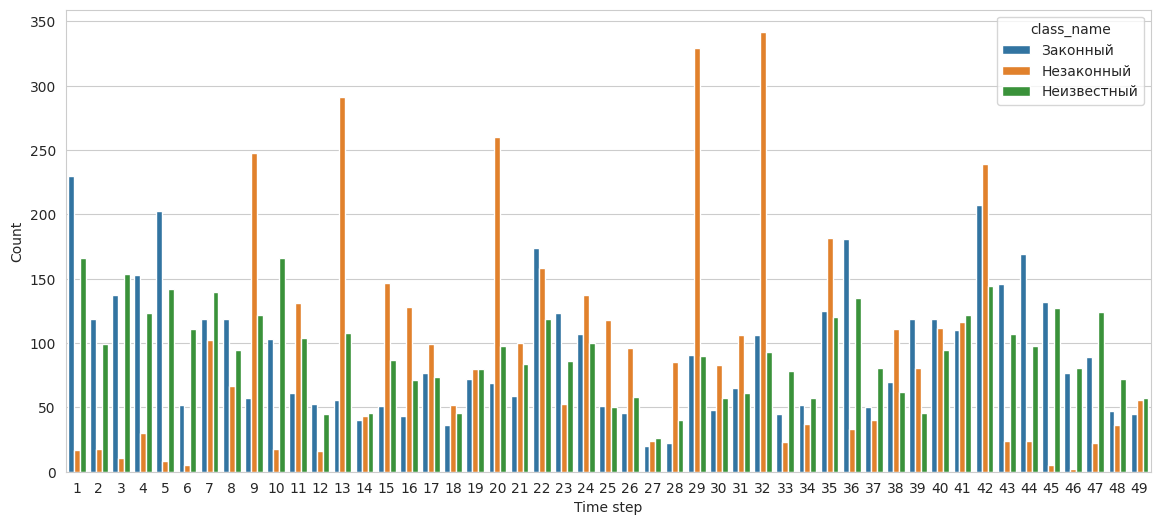

In [ ]:
# Создаем столбчатую диаграмму
plt.figure(figsize=(14, 6))

# Построение диаграммы с помощью Seaborn
sns.barplot(x='Time step', y='count', hue='class_name', data=updated_grouped_data)

# Добавляем метки осей
plt.xlabel('Time step')
plt.ylabel('Count')

# Отображаем график
plt.show()

Визуализируем граф блокчейна

In [ ]:
df_merge[(df_merge['Time step'] == 32) & ((df_merge['class'] == '1'))]['txId']

126121    355009662
126122     91806025
126168    355004152
126170    174938459
126184    355007365
            ...    
130542     58506409
130553    355179804
130557    122932723
130563    355189694
130603    355127781
Name: txId, Length: 342, dtype: int64

In [ ]:
def draw_graph(features, edges, bad_ids):
    """
    Функция, которая строит граф транзакций.

    Parameters:
    features (DataFrame): DataFrame с информацией о транзакциях.
    edges (DataFrame): DataFrame с информацией об отношениях между транзакциями.
    bad_ids (DataFrame): ID транзакций, соответствующие некоторым условиям

    Returns:
    None

    """

    # Извлекаем только те рёбра, которые связаны с плохими ID
    short_edges = edges[edges['txId1'].isin(bad_ids)]

    # Создаем граф из ребер, используя библиотеку NetworkX
    graph = nx.from_pandas_edgelist(short_edges, source='txId1', target='txId2', create_using=nx.DiGraph())

    # Вычисляем позиции узлов с помощью алгоритма Spring layout
    pos = nx.spring_layout(graph)

    # Создаем списки координат для рёбер графа
    edge_x = []
    edge_y = []
    for edge in graph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    # Создаем объект Scatter для рёбер
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='blue'),
        hoverinfo='none',
        mode='lines')

    # Создаем списки координат для узлов графа
    node_x = []
    node_y = []
    node_text = []
    for node in graph.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(node)

    # Создаем объект Scatter для узлов
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            color=[],  # Здесь будут цвета узлов
            size=10,
            colorbar=dict(
                thickness=15,
                title='Transaction Type',
                xanchor='left',
                titleside='right',
                tickmode='array',
                tickvals=[0, 1, 2],
                ticktext=['Unknown', 'Illicit', 'Licit']
            ),
            line_width=2))
    node_trace.text = node_text

    # Присваиваем цвета узлам в соответствии с их типами транзакций
    node_trace.marker.color = pd.to_numeric(features[features['txId'].isin(list(graph.nodes()))]['class'])

    # Создаем фигуру для отображения графа
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title="Illicit Transactions",
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        annotations=[dict(
                            showarrow=True,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002)],
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
    fig.show()


# Извелкаем незаконные транзакции на временном шаге 29
bad_ids = df_merge[(df_merge['Time step'] == 29) & ((df_merge['class'] == '1'))]['txId']

# Строим граф
draw_graph(df_merge, edgelist, bad_ids)

Визуализация данных в векторном пространстве

In [ ]:
# Убираем колонку txId
clean_features = features.drop(columns=['txId'])

# Уменьшение размерности с помощью UMAP
umap_model = umap.UMAP(random_state=42)
X_umap = umap_model.fit_transform(clean_features)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



In [ ]:
def draw_graph_plane(X, c):
    # Строим график
    plt.figure(figsize=(10, 6))

    # Построение диаграммы рассеяния с окрашиванием по определенной колонке
    plt.scatter(X[:, 0], X[:, 1], c=c, cmap='viridis', alpha=0.3)

    # Добавление шкалы цветов
    plt.colorbar(label='class_name')

    # Отображение графика
    plt.show()

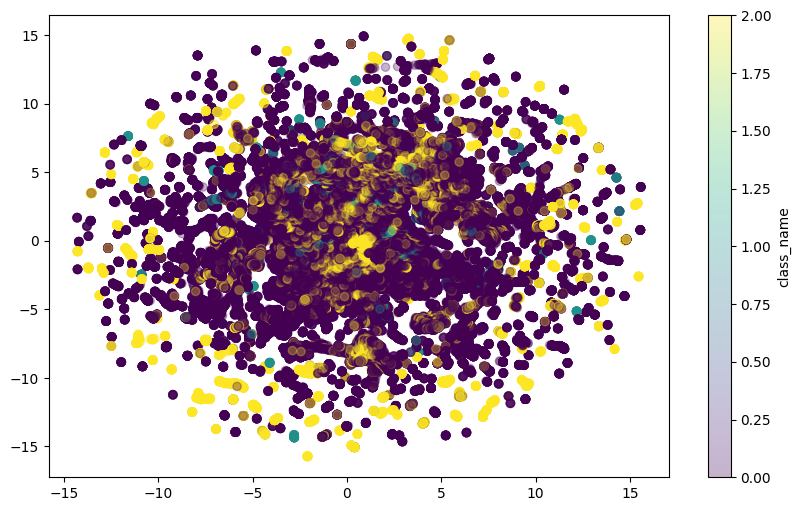

In [ ]:
draw_graph_plane(X_umap, df_merge['class'].astype(int))

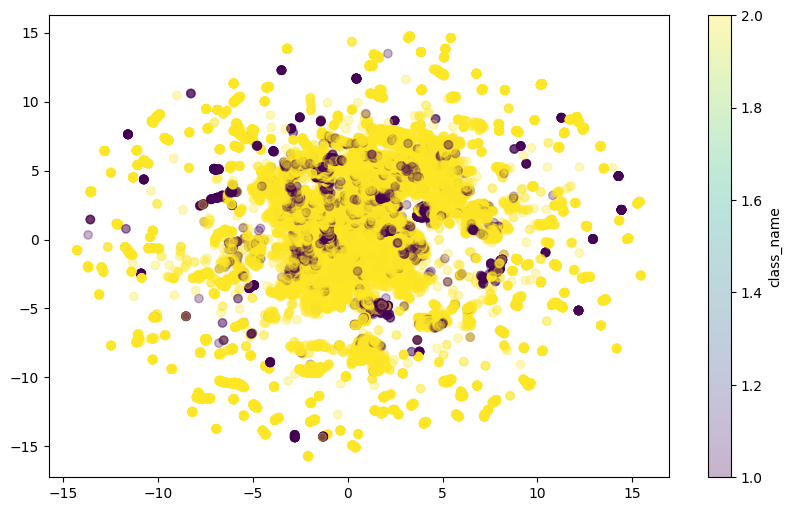

In [ ]:
df_without_know = df_merge[df_merge['class'] != '0']
X_1, c_1 = X_umap[list(df_without_know.index)], df_without_know['class'].astype(int)
draw_graph_plane(X_1, c_1)

Анализируем матрицу корреляции

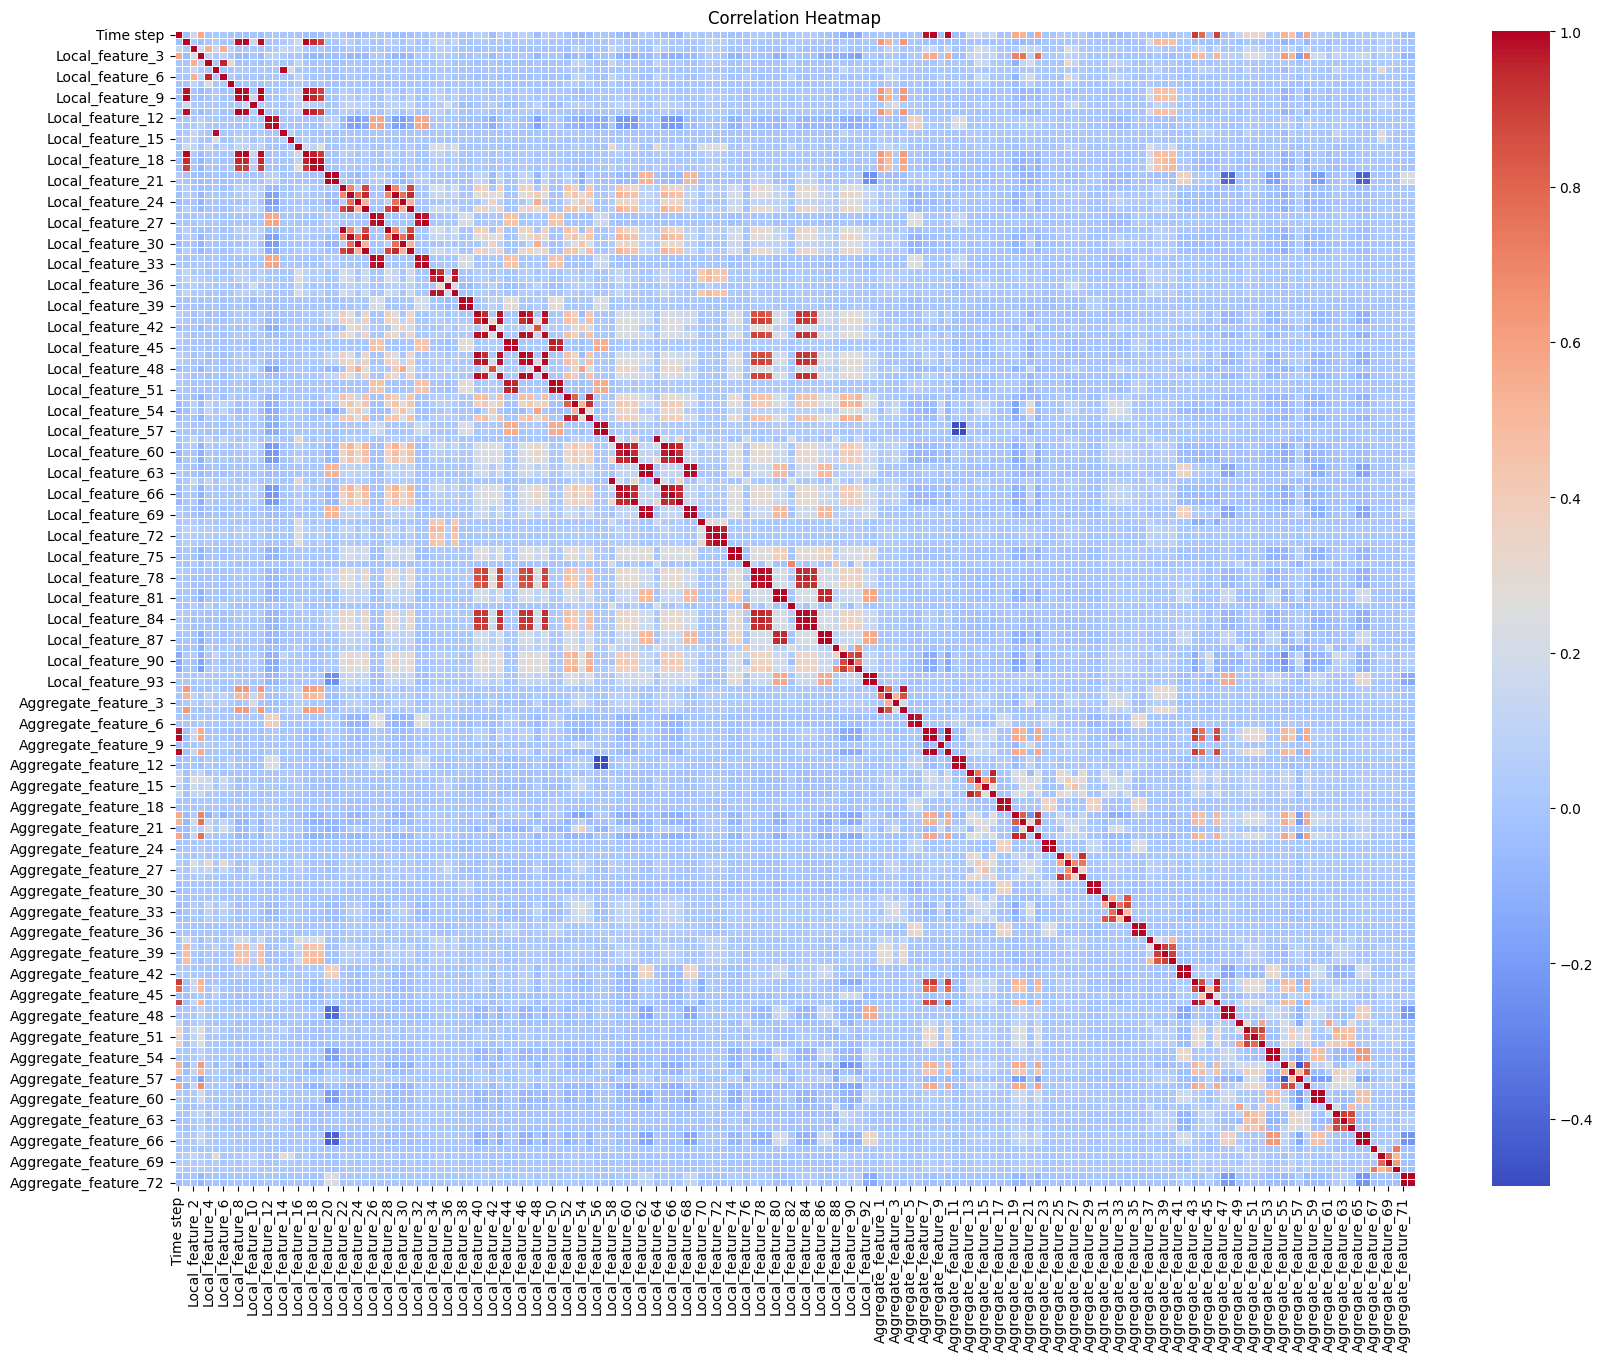

In [ ]:
# Создаем тепловую карту корреляции
correlation_matrix = clean_features.corr()

# Настраиваем стиль и размер графика
plt.figure(figsize=(20, 15))

# Создаем тепловую карту с помощью seaborn
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5, annot=False)

# Добавляем название графика
plt.title('Correlation Heatmap')

# Отображаем график
plt.show()

# ML

Подготавливаем данные к дальнейшему обучению

In [8]:
# Преобразуем к типу int колонку 'class'
df_merge['class'] = df_merge['class'].astype(int)

# Оставляем только те строки, у которых класс 'Законный' или 'Незаконный'
selected_ids = df_merge.loc[(df_merge['class'] != 0), 'txId']
df_edges_selected = edgelist.loc[edgelist['txId1'].isin(selected_ids)]
df_classes_selected = classes.loc[classes['txId'].isin(selected_ids)]
df_features_selected = features.loc[features['txId'].isin(selected_ids)]

# Объединяем в один датасет
df_class_feature_selected = pd.merge(df_classes_selected, df_features_selected)
df_class_feature_selected['class'] = df_class_feature_selected['class_name']\
                                    .apply(lambda x: 0 if x == 'Законный' else 1 )

# Проверяем, что мы действительно убрали строки с классом "Неизвестный"
print(df_class_feature_selected['class_name'].unique())

df_class_feature_selected.drop(columns=['class_name', 'txId', 'Time step'], inplace=True)

# Выводим вид датасета и его размер
print(f'shape df_class_feature_selected --> {df_class_feature_selected.shape}')
df_class_feature_selected.head()

['Законный' 'Незаконный']
shape df_class_feature_selected --> (46564, 166)


,class,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,Local_feature_9,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,0,0.16,1.96,-0.65,12.41,-0.06,9.78,12.41,-0.16,-0.12,...,-0.58,-0.61,0.24,0.24,1.07,0.09,-0.13,0.68,-0.12,-0.12
1,0,-0.01,0.58,-0.09,4.38,-0.06,4.67,0.85,-0.16,-0.14,...,-0.58,-0.61,0.24,0.24,0.60,0.01,-0.13,0.33,-0.12,-0.12
2,0,-0.15,-0.18,-1.20,-0.12,-0.04,-0.11,-0.06,-0.14,-0.14,...,-0.58,-0.61,0.24,0.24,0.02,-0.09,-0.13,-0.10,-0.12,-0.12
3,0,-0.15,-0.18,-1.20,-0.12,-0.04,-0.11,-0.06,-0.14,-0.15,...,-0.54,-0.58,-0.98,-0.98,0.02,-0.09,-0.13,-0.10,-0.12,-0.12
4,0,-0.17,-0.18,-1.20,0.03,-0.04,-0.03,0.24,-0.16,-0.17,...,-0.58,-0.60,0.24,0.24,0.02,-0.07,-0.08,-0.05,-1.76,-1.76


In [19]:
# Разделяем данные на тестовые и тренировочные
X = df_class_feature_selected.drop(columns=['class'])
y = df_class_feature_selected[['class']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=15)

In [20]:
print(f'train shape --> {y_train.shape[0]}')
print(f'test shape --> {y_test.shape[0]}')

train shape --> 34923
test shape --> 11641


## Unsupervised Learning

Обучаем алгоритмы без учителя:

LOF  | OCSVM | CBLOF | ABOD | Isolation Forest

In [11]:
def format_answer(y_pred):
    """
    Функция, которая приводит предсказанные метки в нужный формат (-1 --> 1)
    """
    return list(map(lambda pred: 1 if pred == -1 else 0, y_pred))


# Объявляем словарь используемых моделей
models = {
    'LOF': LocalOutlierFactor(n_neighbors=20, contamination=0.1),
    'OCSVM': OneClassSVM(kernel='rbf', nu=0.1),
    'CBLOF': CBLOF(),
    'ABOD': ABOD(),
    'IF': IsolationForest(contamination=0.1)
}

# Создаем датасет, где будут храниться метрики моделей
df_metrics = pd.DataFrame(index=models.keys(), columns=['accuracy', 'f1-score', 'precision', 'recall', 'balanced_accuracy'])

# Цикл для обучения моделей и оценки их производительности
for name in tqdm(models):
    model = models[name]
    if hasattr(model, 'fit_predict'):
        y_pred = format_answer(model.fit_predict(X))
    else:
        model.fit(X)
        y_pred = format_answer(model.predict(X))
    df_metrics.loc[name, 'accuracy'] = accuracy_score(y, y_pred)
    df_metrics.loc[name, 'f1-score'] = f1_score(y, y_pred)
    df_metrics.loc[name, 'precision'] = precision_score(y, y_pred)
    df_metrics.loc[name, 'recall'] = recall_score(y, y_pred)
    df_metrics.loc[name, 'balanced_accuracy'] = balanced_accuracy_score(y, y_pred)

100%|██████████| 5/5 [05:41<00:00, 68.28s/it]


In [17]:
df_metrics = df_metrics.sort_values(by=['balanced_accuracy'], ascending=False)
df_metrics.style.set_properties(**{'background-color': 'black',
                           'color': 'lawngreen',
                           'border-color': 'white'})

,accuracy,f1-score,precision,recall,balanced_accuracy
LOF,0.826776,0.123451,0.121967,0.124972,0.513830
CBLOF,0.902392,0.000000,0.000000,0.000000,0.500000
ABOD,0.902392,0.000000,0.000000,0.000000,0.500000
OCSVM,0.804248,0.009347,0.009235,0.009461,0.449839
IF,0.802594,0.001087,0.001074,0.001100,0.445194


## Supervised Learning

RandomForest - baseline

Обучаем базовую модель с учителем, с которой затем будем сравнивать точность

In [ ]:
model_RF = RandomForestClassifier().fit(X_train.values,y_train.values)
y_preds = model_RF.predict(X_test.values)

prec, rec, f1, num = precision_recall_fscore_support(y_test.values, y_preds)

print("Random Forest Classifier")
print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f"%(prec[1], rec[1], f1[1]))

<ipython-input-42-09ce10322828>:1: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Random Forest Classifier
Precision: 0.991 
Recall: 0.834 
F1 Score: 0.906


LazyPredict

Lazy Predict помогает создавать множество базовых моделей без большого количества кода и помогает понять, какие модели работают лучше без какой-либо настройки параметров.

Подробнне про него можно почитать [тут](https://github.com/shankarpandala/lazypredict)

In [ ]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

 97%|█████████▋| 28/29 [02:12<00:04,  4.02s/it]

[LightGBM] [Info] Number of positive: 883, number of negative: 8429
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37411
[LightGBM] [Info] Number of data points in the train set: 9312, number of used features: 164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.094824 -> initscore=-2.256108
[LightGBM] [Info] Start training from score -2.256108


100%|██████████| 29/29 [02:16<00:00,  4.72s/it]


In [ ]:
models.style.set_properties(**{'background-color': 'black',
                           'color': 'lawngreen',
                           'border-color': 'white'})

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.985934,0.936970,0.936970,0.985584,4.474786
LGBMClassifier,0.985960,0.936133,0.936133,0.985597,3.758994
AdaBoostClassifier,0.978632,0.921973,0.921973,0.978235,12.692320
DecisionTreeClassifier,0.969075,0.920445,0.920445,0.969308,0.954264
RandomForestClassifier,0.983410,0.919756,0.919756,0.982804,4.473209
BaggingClassifier,0.981263,0.915402,0.915402,0.980616,8.594208
ExtraTreesClassifier,0.981370,0.909136,0.909136,0.980580,2.261405
ExtraTreeClassifier,0.959948,0.897136,0.897136,0.960343,0.274507
LabelPropagation,0.964431,0.891106,0.891106,0.964120,21.144084


TabNet

TabNet — нейросеть из полносвязных слоев с последовательным механизмом внимания, которая:

*   использует разреженный выбор объектов по экземплярам, полученный на основе обучающего набора данных;  
*   создает последовательную многоступенчатую архитектуру, в которой каждый шаг принятия решения может внести свой вклад в ту часть решения, которая основана на выбранных функциях;
*   улучшает способность к обучению путем нелинейных преобразований выбранных функций;
*   имитирует ансамбль, привлекая более точные измерения и больше шагов улучшения решения.

In [18]:
# Подготавливаем данные для обуч
X_train = X_train.iloc[:,:].to_numpy()
y_train = y_train.to_numpy().squeeze()
X_test  = X_test.to_numpy()

# Обучаем классификатор
classifier = TabNetClassifier(verbose=0, seed=42)
classifier.fit(X_train=X_train, y_train=y_train,
               patience=5,max_epochs=100,
               eval_metric=['auc'])

# Оценка качества модели
predictions = classifier.predict_proba(X_test)
predictions_class = [np.argmax(pred) for pred in predictions]
prec, rec, f1, num = precision_recall_fscore_support(y_test.values, predictions_class)

print("TabNet Classifier")
print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f"%(prec[1], rec[1], f1[1]))

TabNet Classifier
Precision: 0.952 
Recall: 0.792 
F1 Score: 0.865


Catboost

In [ ]:
# Создание Pool для CatBoost
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)

# Инициализация и обучение модели CatBoost
model = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, loss_function='Logloss')
model.fit(train_pool, eval_set=test_pool, verbose=100)

# Оценка качества модели
prec, rec, f1, num = precision_recall_fscore_support(y_test.values, y_pred = model.predict(test_pool))

print("Сatboost")
print("Precision: %.3f \nRecall: %.3f \nF1 Score: %.3f"%(prec[1], rec[1], f1[1]))

0:	learn: 0.5343739	test: 0.5367764	best: 0.5367764 (0)	total: 224ms	remaining: 3m 43s
100:	learn: 0.0217332	test: 0.0523723	best: 0.0523723 (100)	total: 6.38s	remaining: 56.8s
200:	learn: 0.0099822	test: 0.0483058	best: 0.0482726 (199)	total: 12.6s	remaining: 50.1s
300:	learn: 0.0057517	test: 0.0478358	best: 0.0477688 (225)	total: 17s	remaining: 39.5s
400:	learn: 0.0037462	test: 0.0495385	best: 0.0477688 (225)	total: 21.5s	remaining: 32.1s
500:	learn: 0.0027125	test: 0.0510137	best: 0.0477688 (225)	total: 28.5s	remaining: 28.3s
600:	learn: 0.0021404	test: 0.0520755	best: 0.0477688 (225)	total: 32.8s	remaining: 21.7s
700:	learn: 0.0018052	test: 0.0528198	best: 0.0477688 (225)	total: 39.9s	remaining: 17s
800:	learn: 0.0015916	test: 0.0533707	best: 0.0477688 (225)	total: 44.2s	remaining: 11s
900:	learn: 0.0014160	test: 0.0540441	best: 0.0477688 (225)	total: 49.3s	remaining: 5.41s
999:	learn: 0.0013088	test: 0.0544104	best: 0.0477688 (225)	total: 56.5s	remaining: 0us

bestTest = 0.0477687

GCN

In [22]:
def load_data(data_dir: str, start_ts: int, end_ts: int):
    """
    Загружает данные из набора данных о биткоин-транзакциях.

    Параметры:
        data_dir (str): Путь к каталогу данных.
        start_ts (int): Временная метка начала загрузки данных.
        end_ts (int): Временная метка конца загрузки данных.

    Возвращает:
        tuple: Кортеж, содержащий списки матриц смежности, признаков и меток классов для каждой временной метки.
    """

    # Задаем пути к CSV-файлам с данными о классах, ребрах и признаках транзакций
    classes_csv = path_to_folder  + '/elliptic_bitcoin_dataset/elliptic_txs_classes.csv'
    edgelist_csv = path_to_folder  + '/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv'
    features_csv = path_to_folder  + '/elliptic_bitcoin_dataset/elliptic_txs_features.csv'

    # Загружаем данные из CSV-файлов в объекты DataFrame библиотеки Pandas
    classes = pd.read_csv(classes_csv, index_col = 'txId') # метки для транзакций
    edgelist = pd.read_csv(edgelist_csv, index_col = 'txId1') # направленные ребра между транзакциями
    features = pd.read_csv(features_csv, header=None, index_col = 0) # признаки транзакций

    num_features = features.shape[1] # количество признаков
    num_tx = features.shape[0] # общее количество транзакций
    total_tx = list(classes.index) # список всех транзакций

    # Выбираем только те транзакции, которые имеют метки
    labelled_classes = classes[classes['class'] != 'unknown']
    labelled_tx = list(labelled_classes.index)

    # Создаем списки для хранения матриц смежности, признаков и меток классов для каждой временной метки
    adj_mats = []
    features_labelled_ts = []
    classes_ts = []
    num_ts = 49 # количество временных меток

    # Цикл по временным меткам
    for ts in range(start_ts, end_ts):
        # Выбираем признаки для данной временной метки
        features_ts = features[features[1] == ts+1]
        tx_ts = list(features_ts.index) # список транзакций для данной временной метки

        # Отбираем только те транзакции, которые имеют метки
        labelled_tx_ts = [tx for tx in tx_ts if tx in set(labelled_tx)]

        # Создаем пустую матрицу смежности для всех транзакций данной временной метки
        adj_mat = pd.DataFrame(np.zeros((num_tx, num_tx)), index = total_tx, columns = total_tx)

        # Заполняем матрицу смежности ребрами между транзакциями
        edgelist_labelled_ts = edgelist.loc[edgelist.index.intersection(labelled_tx_ts).unique()]
        for i in range(edgelist_labelled_ts.shape[0]):
            adj_mat.loc[edgelist_labelled_ts.index[i], edgelist_labelled_ts.iloc[i]['txId2']] = 1

        # Обрезаем матрицу смежности и признаки, оставляя только те, которые имеют метки
        adj_mat_ts = adj_mat.loc[labelled_tx_ts, labelled_tx_ts]
        features_l_ts = features.loc[labelled_tx_ts]

        # Добавляем матрицу смежности и соответствующие признаки и метки классов в списки
        adj_mats.append(adj_mat_ts)
        features_labelled_ts.append(features_l_ts)
        classes_ts.append(classes.loc[labelled_tx_ts])

    return adj_mats, features_labelled_ts, classes_ts

# Загружаем данные
dataSet = load_data(path_to_folder, 0, 34)

In [24]:
class GraphConv(nn.Module):
    def __init__(self, in_features, out_features, activation='relu', skip=False, skip_in_features=None):
        """
        Инициализация слоя графовой свертки.

        Параметры:
            in_features (int): Размер входных признаков.
            out_features (int): Размер выходных признаков.
            activation (str): Тип активации: 'relu' или 'softmax'.
            skip (bool): Флаг использования пропускающего соединения.
            skip_in_features (int): Размер входных признаков для пропускающего соединения.
        """
        super(GraphConv, self).__init__()
        self.W = torch.nn.Parameter(torch.DoubleTensor(in_features, out_features))
        nn.init.xavier_uniform_(self.W)

        self.set_act = False
        if activation == 'relu':
            self.activation = nn.ReLU()
            self.set_act = True
        elif activation == 'softmax':
            self.activation = nn.Softmax(dim=1)
            self.set_act = True
        else:
            self.set_act = False
            raise ValueError("Активационная функция может быть только 'relu' или 'softmax'")

        self.skip = skip
        if self.skip:
            if skip_in_features is None:
                raise ValueError("Необходимо передать размер входного объекта, пропускаемого соединения")
            self.W_skip = torch.nn.Parameter(torch.DoubleTensor(skip_in_features, out_features))
            nn.init.xavier_uniform_(self.W)

    def forward(self, A, H_in, H_skip_in=None):
        """
        Прямой проход через слой графовой свертки.

        Параметры:
            A (torch.Tensor): Матрица смежности (размерность: n x n).
            H_in (torch.Tensor): Входные эмбеддинги узлов (размерность: n x in_features).
            H_skip_in (torch.Tensor): Входные признаки для пропускающего соединения (размерность: n x skip_in_features).

        Возвращает:
            torch.Tensor: Выходные эмбеддинги узлов (размерность: n x out_features).
        """
        self.A = A
        self.H_in = H_in
        A_ = torch.add(self.A, torch.eye(self.A.shape[0]).double())
        D_ = torch.diag(A_.sum(1))
        D_root_inv = torch.inverse(torch.sqrt(D_))
        A_norm = torch.mm(torch.mm(D_root_inv, A_), D_root_inv)

        H_out = torch.mm(torch.mm(A_norm, H_in), self.W)

        if self.skip:
            H_skip_out = torch.mm(H_skip_in, self.W_skip)
            H_out = torch.add(H_out, H_skip_out)

        if self.set_act:
            H_out = self.activation(H_out)

        return H_out

class GCN_2layer(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, skip=False):
        """
        Инициализация двухслойной модели графовой свертки.

        Параметры:
            in_features (int): Размер входных признаков.
            hidden_features (int): Размер скрытых признаков.
            out_features (int): Размер выходных признаков.
            skip (bool): Флаг использования пропускающего соединения.
        """
        super(GCN_2layer, self).__init__()
        self.skip = skip

        self.gcl1 = GraphConv(in_features, hidden_features)

        if self.skip:
            self.gcl_skip = GraphConv(hidden_features, out_features, activation='softmax', skip=self.skip,
                                  skip_in_features=in_features)
        else:
            self.gcl2 = GraphConv(hidden_features, out_features, activation='softmax')

    def forward(self, A, X):
        """
        Прямой проход через двухслойную модель графовой свертки.

        Параметры:
            A (torch.Tensor): Матрица смежности (размерность: n x n).
            X (torch.Tensor): Входные эмбеддинги узлов (размерность: n x in_features).

        Возвращает:
            torch.Tensor: Выходные эмбеддинги узлов (размерность: n x out_features).
        """
        out = self.gcl1(A, X)
        if self.skip:
            out = self.gcl_skip(A, out, X)
        else:
            out = self.gcl2(A, out)

        return out

In [25]:
# Создаем папку, в которой будет храниться обученная модель
model_dir = "./modelDir"
os.makedirs(model_dir, exist_ok=True)

In [28]:
num_features = 166  # Количество признаков
num_classes = 2     # Количество классов
num_ts = 49         # Количество временных рядов
epochs = 15         # Эпохи обучения
lr = 0.001          # Скорость обучения
max_train_ts = 5    # Максимальное количество обучающих временных рядов
train_ts = np.arange(max_train_ts)  # Обучающие временные ряды

# Матрицы смежности, признаки временных рядов, классы временных рядов
adj_mats, features_labelled_ts, classes_ts = dataSet

labels_ts = []  # 0 - незаконный, 1 - законный
for c in classes_ts:
    labels_ts.append(np.array(c['class'] == '2', dtype=np.longlong))

# Создание модели GCN
gcn = GCN_2layer(num_features, 100, num_classes)
train_loss = nn.CrossEntropyLoss(weight=torch.DoubleTensor([0.7, 0.3]))
optimizer = torch.optim.Adam(gcn.parameters(), lr=lr)

# Сохраняем историю обучения
accuracy_arr = []
loss_arr = []

# Обучение
for ts in train_ts:
    A = torch.tensor(adj_mats[ts].values)
    X = torch.tensor(features_labelled_ts[ts].values)
    L = torch.tensor(labels_ts[ts], dtype=torch.long)
    for ep in range(epochs):
        t_start = time.time()

        gcn.train()
        optimizer.zero_grad()
        out = gcn(A, X)

        loss = train_loss(out, L)
        train_pred = out.max(1)[1].type_as(L)
        acc = (train_pred.eq(L).double().sum()) / L.shape[0]

        loss.backward()
        optimizer.step()

        accuracy_arr.append(acc)
        loss_arr.append(loss)

        sys.stdout.write("\r Эпоха %d/%d Временной ряд %d/%d Потери обучения: %f Accuracy: %f Время: %s"
                         % (ep, epochs, ts, max_train_ts, loss, acc, time.time() - t_start)
                         )

# Сохранение весов модели
torch.save(gcn.state_dict(), str(os.path.join("./modelDir", "gcn_weights.pth")))

 Эпоха 14/15 Временной ряд 4/5 Потери обучения: 0.323246 Accuracy: 0.995749 Время: 3.095886468887329

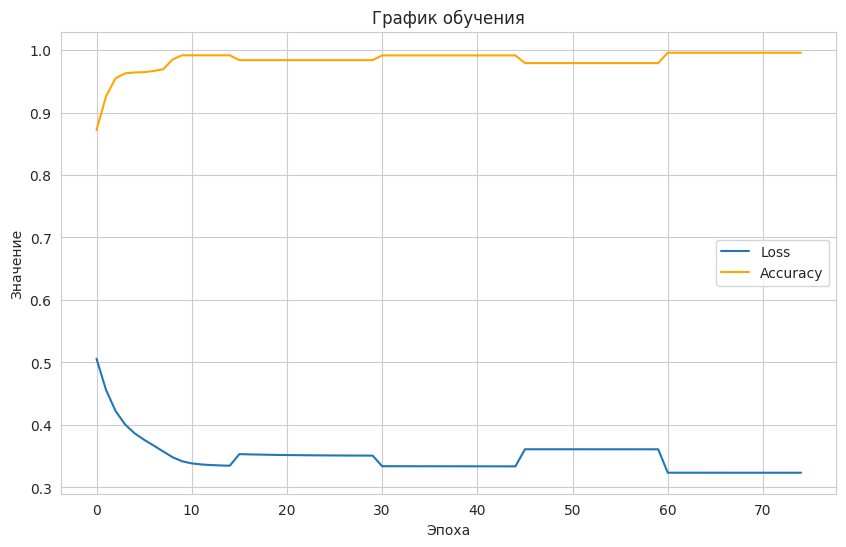

In [35]:
loss_values = [loss.item() for loss in loss_arr]
accuracy_values = [accuracy.item() for accuracy in accuracy_arr]

# Создание графика
plt.figure(figsize=(10, 6))

# График loss
plt.plot(loss_values, label='Loss')

# График accuracy
plt.plot(accuracy_values, color='orange', label='Accuracy')

# Настройка графика
plt.title('График обучения')
plt.xlabel('Эпоха')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)

# Отображение графика
plt.show()

In [ ]:
test_ts = np.arange(14)
adj_mats, features_labelled_ts, classes_ts = load_data(dir, 35, 49)

labels_ts = []
for c in classes_ts:
    labels_ts.append(np.array(c['class'] == '2', dtype=np.int64))

gcn = GCN_2layer(num_features, 100, num_classes)
gcn.load_state_dict(torch.load(os.path.join("./modelDir", "gcn_weights.pth")))

# Тестирование
test_accs = []
test_precisions = []
test_recalls = []
test_f1s = []

for ts in test_ts:
    A = torch.tensor(adj_mats[ts].values)
    X = torch.tensor(features_labelled_ts[ts].values)
    L = torch.tensor(labels_ts[ts], dtype=torch.long)

    gcn.eval()
    test_out = gcn(A, X)

    test_pred = test_out.max(1)[1].type_as(L)
    t_acc = (test_pred.eq(L).double().sum()) / L.shape[0]
    test_accs.append(t_acc.item())
    test_precisions.append(precision_score(L, test_pred))
    test_recalls.append(recall_score(L, test_pred))
    test_f1s.append(f1_score(L, test_pred))

# Вычисление средних значений
acc = np.array(test_accs).mean()
prec = np.array(test_precisions).mean()
rec = np.array(test_recalls).mean()
f1 = np.array(test_f1s).mean()

print('GCN')
print(f"averaged accuracy: {round(acc, 2)}\nprecision: {round(prec, 2)}\nrecall: {round(rec, 2)}\nf1: {round(f1, 2)}")

GCN - averaged accuracy: 0.9319040173223873, precision: 0.9365757362409676, recall: 0.9942318088140275, f1: 0.9639747739880935


In [38]:
!zip -r modelDir.zip /content/modelDir

  adding: content/modelDir/ (stored 0%)
  adding: content/modelDir/gcn_weights.pth (deflated 5%)
